<a href="https://colab.research.google.com/github/Nabila310/2025_Visi-Komputer_TI2A/blob/main/Jobsheet_03_Teknik_Regresi_Gambar_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
Praktikum D2-Menebak Umur Manusia dari Foto Wajah(UTKFace)

In [2]:
# Jalankan ini di awal notebook
from google.colab import files
files.upload()  # pilih file kaggle.json dari komputer Anda


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nabilaramadani","key":"9783115b33e8e7597deb58fbc73c83d9"}'}

In [3]:
import os, shutil

if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print("kaggle.json belum ditemukan. Upload terlebih dahulu.")


✅ Kaggle API siap digunakan.


In [4]:
# Unduh dataset UTKFace (sekali saja)
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("✅ Dataset UTKFace berhasil diekstrak.")


Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
✅ Dataset UTKFace berhasil diekstrak.


Total gambar ditemukan: 23708


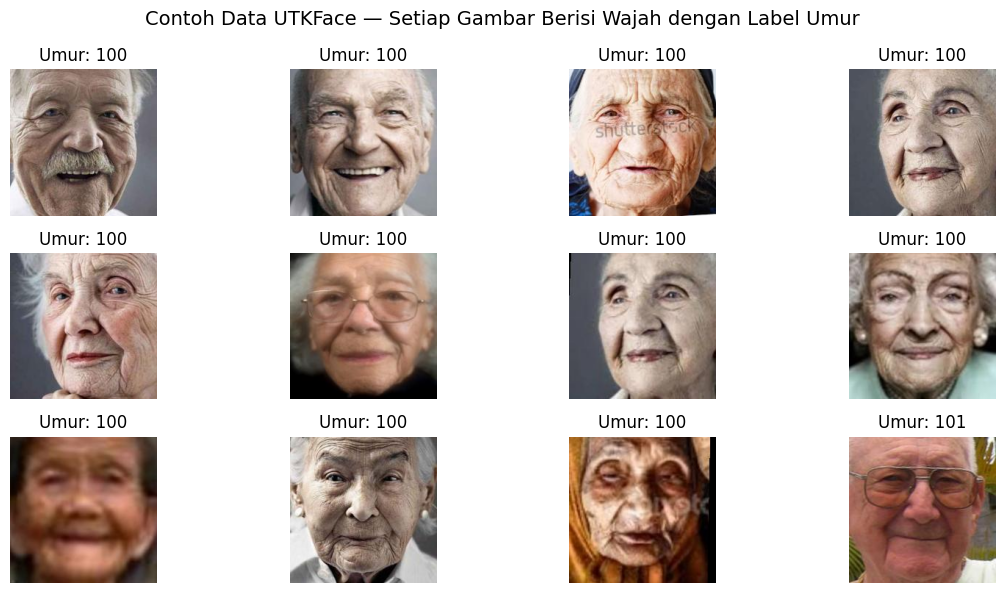

In [5]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image

# Ambil 12 gambar acak dari dataset
files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")

plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]):
    # Ambil umur dari nama file
    age = int(os.path.basename(f).split("_")[0])
    img = Image.open(f)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Umur: {age}")
    plt.axis("off")

plt.suptitle("Contoh Data UTKFace — Setiap Gambar Berisi Wajah dengan Label Umur", fontsize=14)
plt.tight_layout()
plt.show()


In [6]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

def parse_age_from_name(fp):
    return int(os.path.basename(fp).split('_')[0])

ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)

train_files, test_files, y_train, y_test = train_test_split(
    files, ages, test_size=0.2, random_state=42
)

IMG_SIZE = 160

def load_img(fp, label):
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files, y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files, y_test)).map(load_img).batch(64)

print("✅ Dataset siap dilatih.")


✅ Dataset siap dilatih.


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Gunakan GPU jika tersedia
print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

# Buat arsitektur model
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_model.trainable = False  # tahap awal: freeze backbone

# Tambahkan head regresi
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x)  # output tunggal: umur
model = tf.keras.Model(inputs, outputs)

# Kompilasi model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse', metrics=['mae'])

model.summary()


Hardware: GPU
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 63s 148ms/step - loss: 338.7840 - mae: 13.5360 - val_loss: 158.4235 - val_mae: 9.5779 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - loss: 154.9593 - mae: 9.2711 - val_loss: 146.9301 - val_mae: 9.1218 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 143.5869 - mae: 8.8534 - val_loss: 143.4580 - val_mae: 8.9729 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 141.8898 - mae: 8.7490 - val_loss: 138.1910 - val_mae: 8.7261 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 137.1161 - mae: 8.5721 - val_loss: 137.3522 - val_mae: 8.6817 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 133.7648 - mae: 8.4904 - val_loss: 134.7316 - val_mae: 8.5018 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 131.3499 - mae: 8.3938 - val_loss: 133.8099 - va

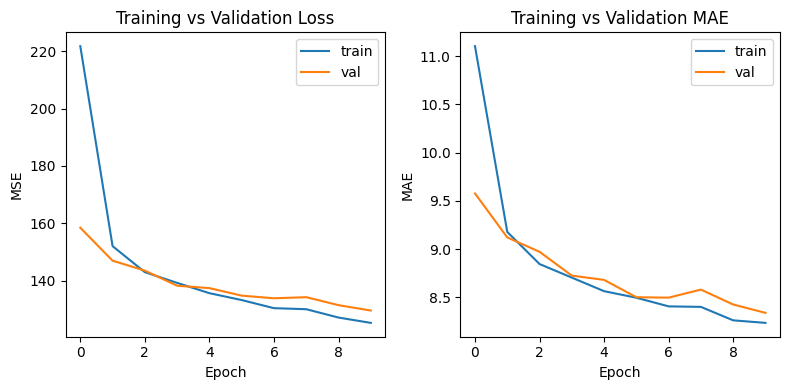

In [8]:
# Callback untuk pelatihan yang lebih stabil
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor='val_loss')
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

# Visualisasi perubahan loss dan MAE selama pelatihan
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()
plt.tight_layout()
plt.show()


Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 59s 142ms/step - loss: 192.1716 - mae: 10.2160 - val_loss: 151.0530 - val_mae: 9.1575 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 46s 49ms/step - loss: 78.1177 - mae: 6.5675 - val_loss: 126.6932 - val_mae: 8.5282 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - loss: 52.8615 - mae: 5.5030 - val_loss: 107.6375 - val_mae: 7.6460 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - loss: 37.5606 - mae: 4.6640 - val_loss: 107.5280 - val_mae: 7.5544 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 29.5715 - mae: 4.1514 - val_loss: 103.9289 - val_mae: 7.4413 - learning_rate: 1.0000e-04


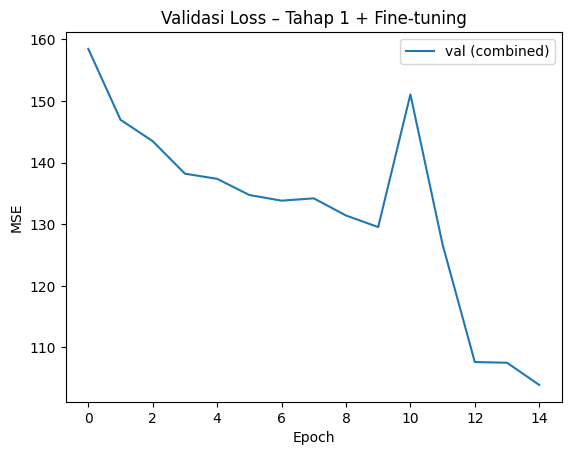

In [9]:
# Aktifkan kembali sebagian layer terakhir untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False  # beku sebagian besar layer

# Recompile dengan learning rate lebih kecil
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse', metrics=['mae'])

history_ft = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=cb,
    verbose=1
)

# Visualisasi gabungan training dan fine-tuning
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label='val (combined)')
plt.title("Validasi Loss – Tahap 1 + Fine-tuning")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()


MAE  = 7.44 tahun
RMSE = 10.19 tahun
R²   = 0.738


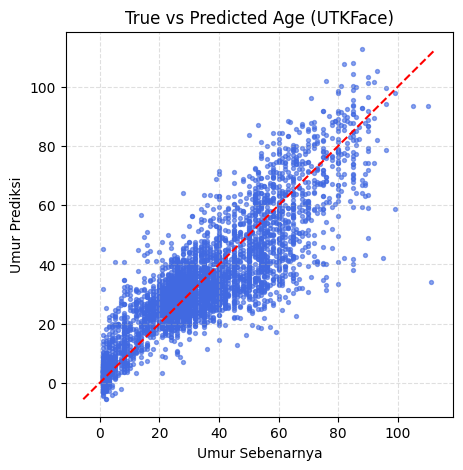

In [10]:
from math import sqrt

y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in test_ds])

mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)

print(f"MAE  = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R²   = {r2:.3f}")

# Plot “umur sebenarnya vs umur prediksi”
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("Umur Sebenarnya")
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


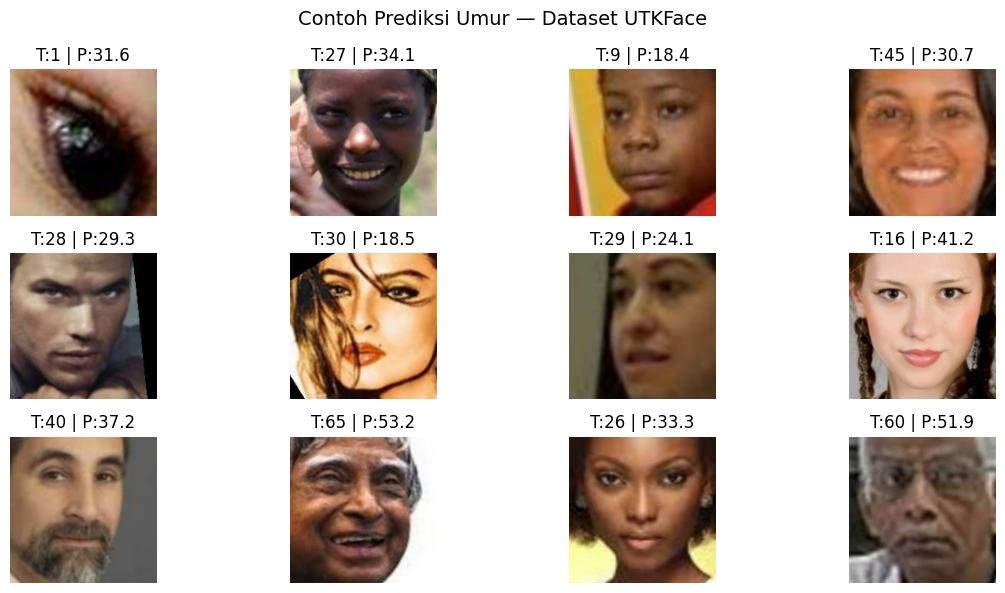

In [11]:
import random

sample_paths = random.sample(test_files, 12)

plt.figure(figsize=(12, 6))
for i, path in enumerate(sample_paths):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    true_age = int(os.path.basename(path).split('_')[0])
    pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]
    plt.subplot(3, 4, i + 1)
    plt.imshow(img.numpy())
    plt.title(f"T:{true_age} | P:{pred_age:.1f}")
    plt.axis('off')

plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()


Tantangan Mini

1. Tambahkan data augmentation ekstra (kontras, brightness, zoom)

In [12]:
from tensorflow.keras import layers

# augmentation layer
data_augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1) if hasattr(layers, "RandomBrightness") else layers.RandomContrast(0.05)
], name="data_augment")

# rebuild dataset pipeline with augmentation applied to training set
def load_img_aug(fp, label):
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = data_augment(img)
    return img, label

train_ds_aug = tf.data.Dataset.from_tensor_slices((train_files, y_train)) \
    .map(load_img_aug, num_parallel_calls=tf.data.AUTOTUNE) \
    .shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)

# Re-train head only quickly (use fewer epochs for demo)
model_aug = tf.keras.models.clone_model(model)  # clone architecture (weights not preserved)
# compile and set base_model freeze as earlier
base_model = model.layers[1] if len(model.layers) > 1 else None
# simpler: recompile existing model and fit with augmented ds (small epochs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse', metrics=['mae'])
history_aug = model.fit(train_ds_aug, validation_data=test_ds, epochs=5, callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)])


Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 158s 390ms/step - loss: 504.1975 - mae: 16.6780 - val_loss: 316.5956 - val_mae: 14.7021
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 126s 341ms/step - loss: 354.9043 - mae: 14.4348 - val_loss: 311.7667 - val_mae: 14.5225
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 124s 338ms/step - loss: 343.6166 - mae: 14.2088 - val_loss: 451.4662 - val_mae: 18.3785
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 142s 339ms/step - loss: 330.2040 - mae: 13.8272 - val_loss: 382.2102 - val_mae: 16.8218


2. Ubah learning rate schedule atau optimizer

In [13]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=opt, loss='mse', metrics=['mae'])

history_sched = model.fit(train_ds, validation_data=test_ds, epochs=6, callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)])


Epoch 1/6
297/297 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 125.1774 - mae: 8.0689 - val_loss: 2474.1306 - val_mae: 47.6390
Epoch 2/6
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - loss: 66.6872 - mae: 5.9472 - val_loss: 2007.0342 - val_mae: 42.5800
Epoch 3/6
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - loss: 47.9917 - mae: 5.1078 - val_loss: 1245.5879 - val_mae: 31.3896
Epoch 4/6
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - loss: 37.2950 - mae: 4.5319 - val_loss: 415.6791 - val_mae: 16.6889
Epoch 5/6
297/297 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - loss: 31.2509 - mae: 4.1712 - val_loss: 610.7528 - val_mae: 20.8356
Epoch 6/6
297/297 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - loss: 28.9122 - mae: 4.0113 - val_loss: 567.5031 - val_mae: 19.6709


3. Pisahkan dataset per kelompok umur dan hitung MAE per kelompok (0–10,11–20,...)

In [28]:
# D2-Challenge 3: evaluate per age group
import pandas as pd

df_test = pd.DataFrame({'path': test_files, 'age': y_test})
bins = list(range(0, 101, 10))  # 0-9,10-19,...
labels = [f"{b}-{b+9}" for b in bins[:-1]]
df_test['age_group'] = pd.cut(df_test['age'], bins=bins, labels=labels, right=False)

# Predict all test images
y_pred_all = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in test_ds])
test_order = []
for batch in test_ds:
    for p in batch[0].numpy():
        test_order.append(p)

y_preds_list = []
for fp in df_test['path'].values:
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    pred = model.predict(tf.expand_dims(img,0), verbose=0).ravel()[0]
    y_preds_list.append(pred)
df_test['pred'] = y_preds_list


group_mae = df_test.groupby('age_group').apply(lambda g: mean_absolute_error(g['age'], g['pred']))
print("MAE per age group:")
print(group_mae)


MAE per age group:
age_group
0-9      17.800756
10-19     5.663658
20-29     7.207882
30-39    16.128384
40-49    25.478151
50-59    35.332623
60-69    44.520550
70-79    54.463932
80-89    64.674629
90-99    73.088058
dtype: float64


/tmp/ipython-input-2147551838.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mae = df_test.groupby('age_group').apply(lambda g: mean_absolute_error(g['age'], g['pred']))
/tmp/ipython-input-2147551838.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_mae = df_test.groupby('age_group').apply(lambda g: mean_absolute_error(g['age'], g['pred']))


4. Uji model pada foto pribadi (ganti path ke foto kamu)

Predicted age: 18.84 years


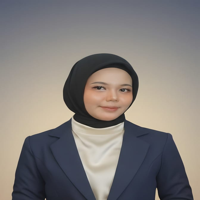

In [29]:
# D2-Challenge 4: predict your own image
YOUR_IMAGE_PATH = "/content/Nabila.jpeg"

from PIL import Image
if os.path.exists(YOUR_IMAGE_PATH):
    img = tf.io.read_file(YOUR_IMAGE_PATH)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    pred_age = model.predict(tf.expand_dims(img,0), verbose=0).ravel()[0]
    print(f"Predicted age: {pred_age:.2f} years")
    display(Image.open(YOUR_IMAGE_PATH).resize((200,200)))
else:
    print(f"File not found at {YOUR_IMAGE_PATH}. Upload your image to this path first.")


Praktikum D1-Regresi dan Citra Sintesis(Prediksi Radius lingkaran)

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models

# Generator 1 sample
def make_sample(img_size=64, min_r=5, max_r=20):
    r = np.random.randint(min_r, max_r + 1)  # radius acak
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    cx = np.random.randint(r, img_size - r)  # center-x
    cy = np.random.randint(r, img_size - r)  # center-y
    cv2.circle(img, (cx, cy), r, (255,), -1)  # lingkaran putih terisi
    img = (img / 255.0).astype(np.float32)
    # 3-channel biar kompatibel CNN
    img3 = np.stack([img, img, img], axis=-1)
    return img3, float(r), (cx, cy)


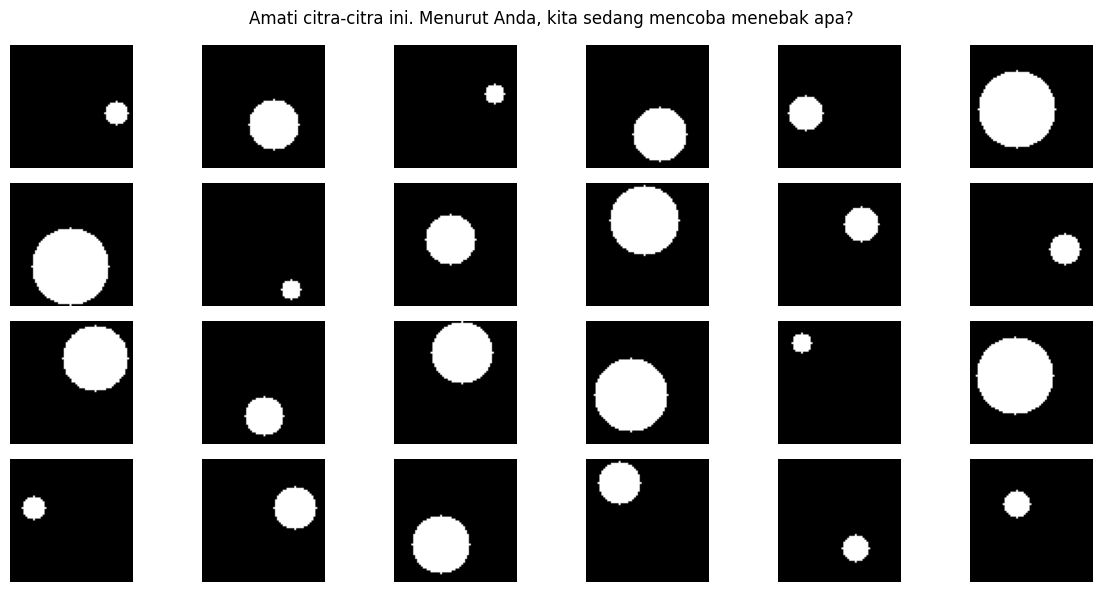

In [19]:
# Buat 24 contoh untuk visualisasi
N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]

# Grid gambar tanpa label
cols = 6
rows = N_show // cols

plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.axis('off')

plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba menebak apa?")
plt.tight_layout()
plt.show()


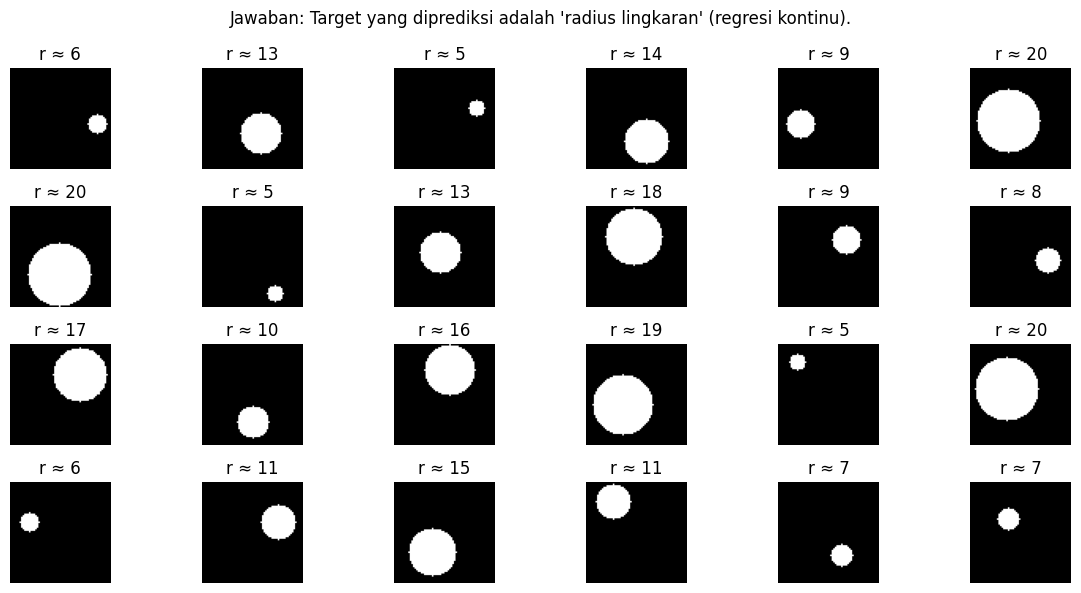

In [20]:
# Tampilkan kembali, sekarang tampilkan radius (label) di judul tiap subplot
plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(f"r ≈ {int(rads[i])}")
    plt.axis('off')

plt.suptitle("Jawaban: Target yang diprediksi adalah 'radius lingkaran' (regresi kontinu).")
plt.tight_layout()
plt.show()


In [21]:
# Siapkan dataset lebih besar untuk training
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Model CNN sederhana
model = models.Sequential([
    layers.Input((64,64,3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # output regresi
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    Xtr, ytr,
    validation_data=(Xte, yte),
    epochs=12,
    batch_size=64,
    verbose=1
)


Epoch 1/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - loss: 101.9236 - mae: 8.4028 - val_loss: 3.8957 - val_mae: 1.5140
Epoch 2/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.5541 - mae: 1.4870 - val_loss: 1.7422 - val_mae: 1.0303
Epoch 3/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6817 - mae: 1.0487 - val_loss: 1.5686 - val_mae: 1.0297
Epoch 4/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6584 - mae: 1.0633 - val_loss: 1.5736 - val_mae: 0.9933
Epoch 5/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5916 - mae: 1.0217 - val_loss: 1.4711 - val_mae: 0.9830
Epoch 6/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5254 - mae: 1.0117 - val_loss: 1.4774 - val_mae: 0.9695
Epoch 7/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5673 - mae: 1.0195 - val_loss: 1.4762 - val_mae: 0.9627
Epoch 8/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5072 - mae: 1.0090 - val_loss: 1.3875 - val_mae: 0.9616
Epoch 9/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5

In [22]:
# Evaluasi
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred)**2)))
r2 = r2_score(yte, y_pred)

print(f"MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
MAE=1.063 | RMSE=1.281 | R²=0.918


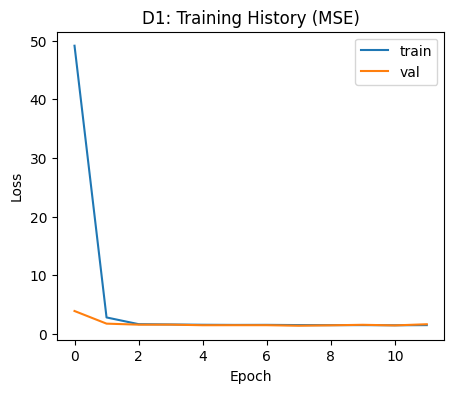

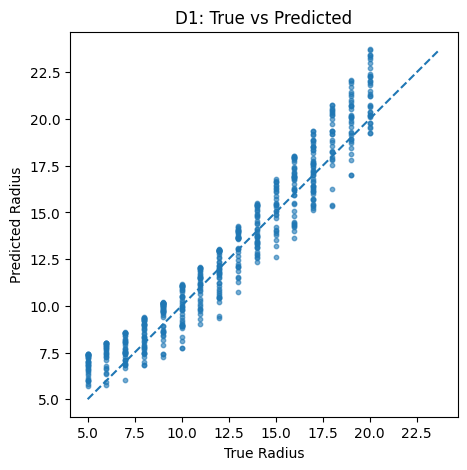

In [23]:
# Plot loss
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Scatter True vs Predicted
plt.figure(figsize=(5,5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius")
plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.show()


Tantangan Mini

1.

In [24]:
# D1-Challenge 1: rentang radius 8..28
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

def make_sample_range(img_size=64, min_r=8, max_r=28):
    r = np.random.randint(min_r, max_r + 1)
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    cx = np.random.randint(r, img_size - r)
    cy = np.random.randint(r, img_size - r)
    cv2.circle(img, (cx, cy), r, (255,), -1)
    img = (img / 255.0).astype(np.float32)
    img3 = np.stack([img, img, img], axis=-1)
    return img3, float(r)

# Generate dataset
N = 3000
X, y = zip(*[make_sample_range() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

# Split
from sklearn.model_selection import train_test_split
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Reuse same model architecture (reinit weights)
def build_small_cnn():
    m = models.Sequential([
        layers.Input((64,64,3)),
        layers.Conv2D(32,3,activation='relu'), layers.MaxPooling2D(),
        layers.Conv2D(64,3,activation='relu'), layers.MaxPooling2D(),
        layers.Conv2D(128,3,activation='relu'), layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    m.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return m

model_range = build_small_cnn()
hist = model_range.fit(Xtr, ytr, validation_data=(Xte,yte), epochs=8, batch_size=64, verbose=1)

# Eval
y_pred = model_range.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = np.sqrt(np.mean((yte - y_pred)**2))
r2 = r2_score(yte, y_pred)
print(f"[D1-range 8-28] MAE={mae:.3f} RMSE={rmse:.3f} R2={r2:.3f}")


Epoch 1/8
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 211.6832 - mae: 12.2755 - val_loss: 6.0626 - val_mae: 2.1358
Epoch 2/8
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.6570 - mae: 1.7698 - val_loss: 1.1614 - val_mae: 0.8758
Epoch 3/8
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.1524 - mae: 0.8816 - val_loss: 1.0056 - val_mae: 0.8185
Epoch 4/8
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.1041 - mae: 0.8451 - val_loss: 0.9536 - val_mae: 0.7910
Epoch 5/8
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.0489 - mae: 0.8332 - val_loss: 0.9419 - val_mae: 0.7929
Epoch 6/8
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.9843 - mae: 0.8039 - val_loss: 0.9233 - val_mae: 0.7712
Epoch 7/8
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9715 - mae: 0.7953 - val_loss: 0.9681 - val_mae: 0.8033
Epoch 8/8
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0472 - mae: 0.8325 - val_loss: 0.8998 - val_mae: 0.7691
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
[D1-range 8-28] MAE=0.769 RMS

2.

In [25]:
# D1-Challenge 2: add Gaussian blur and Gaussian noise
import cv2, random

def add_noise_blur(img, sigma_noise=0.05, ksize=5):
    # img: float32 in [0,1]
    a = (img*255).astype(np.uint8)
    blurred = cv2.GaussianBlur(a, (ksize,ksize), 0)
    blurred = blurred.astype(np.float32) / 255.0
    # gaussian noise
    noise = np.random.normal(0, sigma_noise, blurred.shape).astype(np.float32)
    noised = np.clip(blurred + noise, 0.0, 1.0)
    return noised

# Generate dataset with noise/blur
def make_sample_noisy(img_size=64, min_r=5, max_r=20, sigma=0.06, ksize=5):
    img3, r, _ = make_sample(img_size=min_r) if False else make_sample(img_size=img_size, min_r=min_r, max_r=max_r)  # reuse original
    # apply blur+noise to single-channel then stack
    gray = img3[...,0]
    aug = add_noise_blur(gray, sigma_noise=sigma, ksize=ksize)
    img_aug = np.stack([aug, aug, aug], axis=-1)
    return img_aug, r

N = 3000
Xn, yn = zip(*[make_sample_noisy() for _ in range(N)])
Xn = np.array(Xn, dtype=np.float32)
yn = np.array(yn, dtype=np.float32)
Xtr_n, Xte_n, ytr_n, yte_n = train_test_split(Xn, yn, test_size=0.2, random_state=42)

model_noise = build_small_cnn()
hist_n = model_noise.fit(Xtr_n, ytr_n, validation_data=(Xte_n,yte_n), epochs=8, batch_size=64, verbose=1)

y_pred_n = model_noise.predict(Xte_n).ravel()
mae_n = mean_absolute_error(yte_n, y_pred_n)
rmse_n = np.sqrt(np.mean((yte_n - y_pred_n)**2))
r2_n = r2_score(yte_n, y_pred_n)
print(f"[D1-noise] MAE={mae_n:.3f} RMSE={rmse_n:.3f} R2={r2_n:.3f}")


Epoch 1/8
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 106.3068 - mae: 8.4790 - val_loss: 3.8590 - val_mae: 1.5321
Epoch 2/8
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.2301 - mae: 1.1761 - val_loss: 1.4941 - val_mae: 0.9733
Epoch 3/8
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4579 - mae: 0.9758 - val_loss: 1.5229 - val_mae: 1.0170
Epoch 4/8
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3838 - mae: 0.9539 - val_loss: 1.4262 - val_mae: 0.9591
Epoch 5/8
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3372 - mae: 0.9330 - val_loss: 1.4112 - val_mae: 0.9590
Epoch 6/8
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3057 - mae: 0.9213 - val_loss: 1.4020 - val_mae: 0.9577
Epoch 7/8
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4136 - mae: 0.9610 - val_loss: 1.3954 - val_mae: 0.9545
Epoch 8/8
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3308 - mae: 0.9353 - val_loss: 1.4067 - val_mae: 0.9503
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
[D1-noise] MAE=0.950 RMSE=1.18

3.

In [26]:
# D1-Challenge 3: multi-output regression [r, cx, cy]
def make_sample_multi(img_size=64, min_r=5, max_r=20):
    r = np.random.randint(min_r, max_r + 1)
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    cx = np.random.randint(r, img_size - r)
    cy = np.random.randint(r, img_size - r)
    cv2.circle(img, (cx, cy), r, (255,), -1)
    img = (img / 255.0).astype(np.float32)
    img3 = np.stack([img, img, img], axis=-1)
    return img3, np.array([r, cx, cy], dtype=np.float32)

N = 3000
X_m, Y_m = zip(*[make_sample_multi() for _ in range(N)])
X_m = np.array(X_m, dtype=np.float32)
Y_m = np.array(Y_m, dtype=np.float32)
Xtrm, Xtem, Ytrm, Ytem = train_test_split(X_m, Y_m, test_size=0.2, random_state=42)

# Model output 3 neurons
def build_multi_output_cnn():
    m = models.Sequential([
        layers.Input((64,64,3)),
        layers.Conv2D(32,3,activation='relu'), layers.MaxPooling2D(),
        layers.Conv2D(64,3,activation='relu'), layers.MaxPooling2D(),
        layers.Conv2D(128,3,activation='relu'), layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(3)  # r, cx, cy
    ])
    m.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return m

model_multi = build_multi_output_cnn()
hist_multi = model_multi.fit(Xtrm, Ytrm, validation_data=(Xtem, Ytem), epochs=12, batch_size=64, verbose=1)

# Eval: compute MAE per component
Ypred_m = model_multi.predict(Xtem)
mae_r = mean_absolute_error(Ytem[:,0], Ypred_m[:,0])
mae_cx = mean_absolute_error(Ytem[:,1], Ypred_m[:,1])
mae_cy = mean_absolute_error(Ytem[:,2], Ypred_m[:,2])
print(f"[D1-multi] MAE_r={mae_r:.3f}, MAE_cx={mae_cx:.3f}, MAE_cy={mae_cy:.3f}")


Epoch 1/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 614.4517 - mae: 20.6936 - val_loss: 174.1724 - val_mae: 8.9698
Epoch 2/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 149.4636 - mae: 8.5802 - val_loss: 87.1279 - val_mae: 7.3004
Epoch 3/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 85.9521 - mae: 7.2976 - val_loss: 81.2305 - val_mae: 6.9435
Epoch 4/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 81.6281 - mae: 6.9580 - val_loss: 75.1026 - val_mae: 6.4751
Epoch 5/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 74.8253 - mae: 6.4116 - val_loss: 68.4844 - val_mae: 6.0047
Epoch 6/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 68.8557 - mae: 6.0133 - val_loss: 61.0285 - val_mae: 5.5853
Epoch 7/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 62.7103 - mae: 5.6743 - val_loss: 55.8046 - val_mae: 5.3807
Epoch 8/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 48.4435 - mae: 4.9866 - val_loss: 39.9669 - val_mae: 4.5537
Epoch 9/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11m

Praktikum D3-Menilai "Kepopuleran Hewan Peliharaan" dari Foto(Pawpuliarity)

Langkah 1

In [38]:
from google.colab import files
files.upload()  # pilih kaggle.json dari komputer Anda

import os, shutil
if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print("❌ kaggle.json belum ditemukan. Upload terlebih dahulu.")


Saving petfinder-pawpularity-score.zip to petfinder-pawpularity-score.zip
✅ Kaggle API siap digunakan.


Langkah 2

In [40]:
!kaggle competitions download -c petfinder-pawpularity-score -p /content -q
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw
print("✅ Dataset Pawpularity berhasil diekstrak.")


✅ Dataset Pawpularity berhasil diekstrak.


Langkah 3

                                 Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                path  
0  /content/p

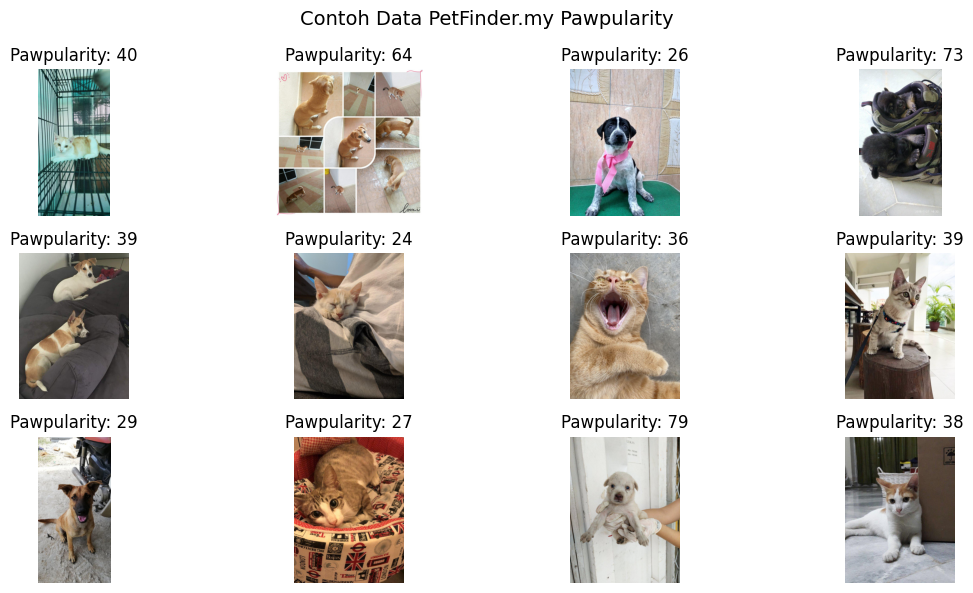

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# Muat CSV
df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")
print(df.head())

# Tampilkan 12 contoh gambar
plt.figure(figsize=(12, 6))
for i, row in enumerate(df.sample(12, random_state=42).itertuples()):
    img = Image.open(row.path)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Pawpularity: {row.Pawpularity}")
    plt.axis('off')

plt.suptitle("Contoh Data PetFinder.my Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()


Langkah 4

In [5]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

IMG_SIZE = 224

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(label, tf.float32)

train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity'])) \
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE) \
    .shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'], val_df['Pawpularity'])) \
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(64).prefetch(tf.data.AUTOTUNE)

print(f"✅ Dataset siap digunakan — {len(train_df)} untuk training, {len(val_df)} untuk validasi.")


✅ Dataset siap digunakan — 7929 untuk training, 1983 untuk validasi.


Langkah 5

In [6]:
from tensorflow.keras import layers, models

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base.trainable = False  # freeze sementara

inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Langkah 6

In [7]:
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)


Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 115s 526ms/step - loss: 839.7250 - mae: 21.8371 - val_loss: 475.9307 - val_mae: 16.1815 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 38s 201ms/step - loss: 419.5378 - mae: 15.2189 - val_loss: 425.8993 - val_mae: 15.1826 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 198ms/step - loss: 384.5251 - mae: 14.4326 - val_loss: 402.5769 - val_mae: 14.8856 - learning_rate: 0.0010
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 200ms/step - loss: 366.1939 - mae: 14.2429 - val_loss: 389.7279 - val_mae: 14.4278 - learning_rate: 0.0010
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 43s 240ms/step - loss: 364.4694 - mae: 14.1686 - val_loss: 381.2486 - val_mae: 14.5545 - learning_rate: 0.0010
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 42s 237ms/step - loss: 331.9142 - mae: 13.5246 - val_loss: 372.9647 - val_mae: 14.3665 - learning_rate: 0.0010
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 43s 241ms/step - loss: 344.4799 - mae: 13.7244 - val_

Langkah 7

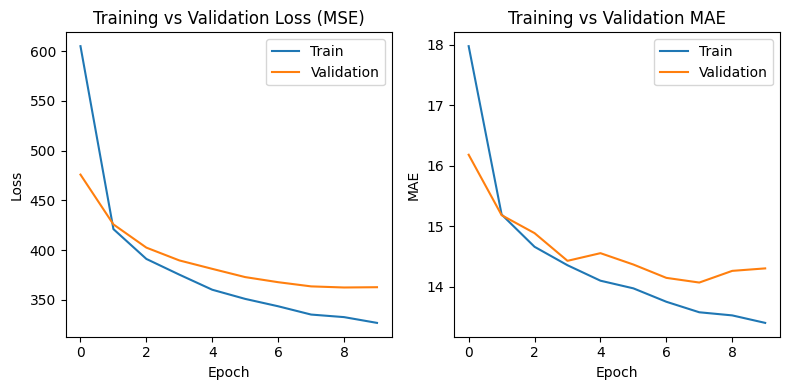

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Training vs Validation Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()

plt.tight_layout()
plt.show()


Langkah 8

MAE  = 14.26
RMSE = 19.04
R²   = 0.180


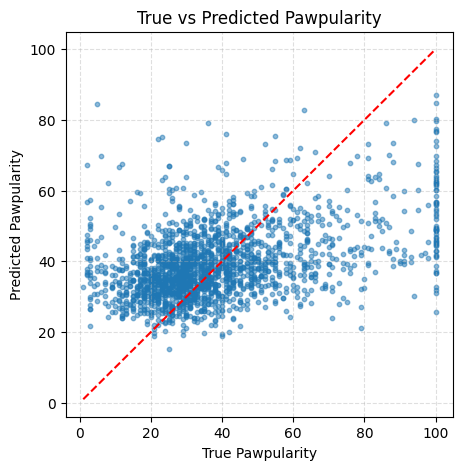

In [9]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in val_ds])

mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(np.mean((y_true - y_pred)**2))
r2 = r2_score(y_true, y_pred)

print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")

plt.figure(figsize=(5, 5))
plt.scatter(y_true, y_pred, s=10, alpha=0.5)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("True Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("True vs Predicted Pawpularity")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


Langkah 9(optiononal)

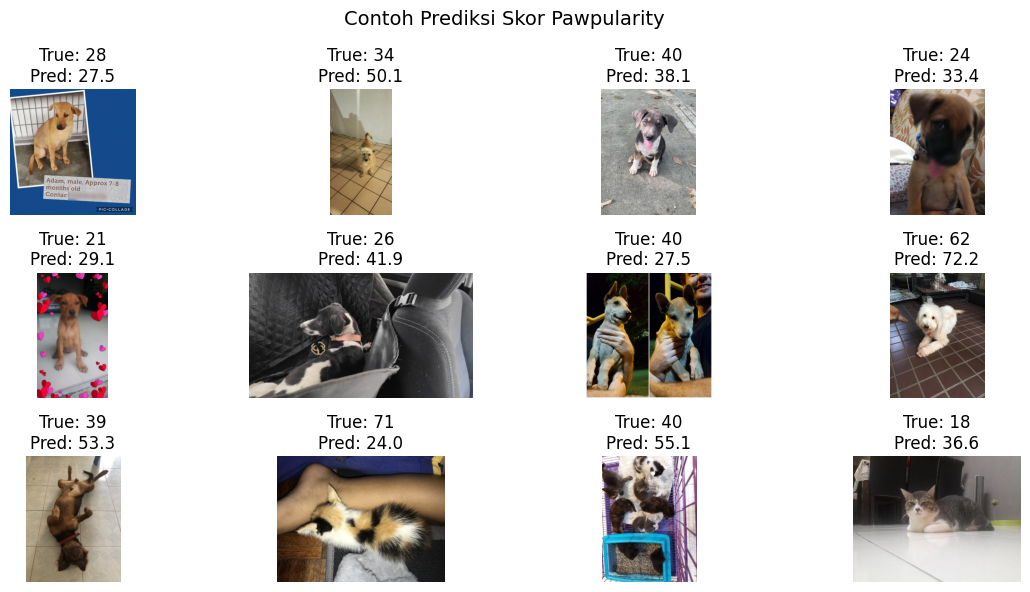

In [10]:
import random
from PIL import Image

sample_rows = val_df.sample(12, random_state=1)

plt.figure(figsize=(12, 6))
for i, row in enumerate(sample_rows.itertuples()):
    img = Image.open(row.path)
    pred = model.predict(tf.expand_dims(load_image(row.path, row.Pawpularity)[0], 0), verbose=0).ravel()[0]
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"True: {row.Pawpularity}\nPred: {pred:.1f}")
    plt.axis('off')

plt.suptitle("Contoh Prediksi Skor Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()


Tantangan Mini

Tambahkan Data Augmentation

In [11]:
from tensorflow.keras import layers

augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

def load_aug(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    img = augment(img)
    return img, tf.cast(label, tf.float32)

train_ds_aug = tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity'])) \
    .map(load_aug, num_parallel_calls=tf.data.AUTOTUNE) \
    .shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)

model.fit(train_ds_aug, validation_data=val_ds, epochs=5)


Epoch 1/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 124s 569ms/step - loss: 342.3573 - mae: 13.7713 - val_loss: 359.8675 - val_mae: 13.9330
Epoch 2/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 137s 546ms/step - loss: 331.6455 - mae: 13.5894 - val_loss: 360.5124 - val_mae: 13.8440
Epoch 3/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 117s 532ms/step - loss: 322.5827 - mae: 13.4251 - val_loss: 354.4305 - val_mae: 13.8985
Epoch 4/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 114s 505ms/step - loss: 328.1663 - mae: 13.4357 - val_loss: 359.5885 - val_mae: 13.8427
Epoch 5/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 140s 499ms/step - loss: 317.4304 - mae: 13.2319 - val_loss: 353.3590 - val_mae: 13.9525


Gunakan EfficientNetB3 atau ResNet50

In [12]:
from tensorflow.keras import layers, models

base_b3 = tf.keras.applications.EfficientNetB3(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_b3.trainable = False

inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base_b3(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model_b3 = tf.keras.Model(inputs, outputs)
model_b3.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_b3.fit(train_ds, validation_data=val_ds, epochs=5)


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 148s 712ms/step - loss: 922.8278 - mae: 23.1209 - val_loss: 493.2857 - val_mae: 16.1910
Epoch 2/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 43s 240ms/step - loss: 463.7958 - mae: 15.8566 - val_loss: 420.5729 - val_mae: 15.1453
Epoch 3/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 87s 272ms/step - loss: 403.0338 - mae: 14.8634 - val_loss: 393.8401 - val_mae: 14.7567
Epoch 4/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 76s 237ms/step - loss: 372.5762 - mae: 14.2921 - val_loss: 383.7864 - val_mae: 14.3331
Epoch 5/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 85s 263ms/step - loss: 362.6225 - mae: 14.2142 - val_loss: 372.8566 - val_mae: 14.1795


Pisahkan Anjing vs Kucing

In [16]:
if 'Type' in df.columns:
    df['Type_name'] = df['Type'].map({1: 'Dog', 2: 'Cat'})
    print(df['Type_name'].value_counts())

    df_dog = df[df['Type'] == 1]
    df_cat = df[df['Type'] == 2]

    def make_ds(sub_df):
        return tf.data.Dataset.from_tensor_slices((sub_df['path'], sub_df['Pawpularity'])) \
            .map(load_image, num_parallel_calls=tf.data.AUTOTUNE) \
            .batch(64).prefetch(tf.data.AUTOTUNE)

    dog_ds = make_ds(df_dog)
    cat_ds = make_ds(df_cat)

    def eval_ds(ds, name):
        y_t = np.concatenate([b[1].numpy() for b in ds])
        y_p = np.concatenate([model.predict(b[0], verbose=0).ravel() for b in ds])
        mae = mean_absolute_error(y_t, y_p)
        print(f"{name} MAE = {mae:.3f}")

    eval_ds(dog_ds, "Dog")
    eval_ds(cat_ds, "Cat")
else:
    print("Kolom 'Type' tidak ditemukan pada dataset.")


Kolom 'Type' tidak ditemukan pada dataset.


Tambahkan Fitur Non-Visual (Brightness)

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models

def compute_brightness(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return tf.reduce_mean(img).numpy()

df['brightness'] = df['path'].apply(lambda p: compute_brightness(p))

def load_with_feat(path, label, brightness):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return (img, brightness), tf.cast(label, tf.float32)

paths = df['path'].values
labels = df['Pawpularity'].values.astype(np.float32)
brights = df['brightness'].values.astype(np.float32)

ds_feat = tf.data.Dataset.from_tensor_slices((paths, labels, brights)).map(
    lambda p, l, b: load_with_feat(p, l, b), num_parallel_calls=tf.data.AUTOTUNE
).batch(32).prefetch(tf.data.AUTOTUNE)

# Custom layer to reshape scalar input
class ReshapeFeature(layers.Layer):
    def call(self, inputs):
        return tf.reshape(inputs, (-1, 1))

# Model dengan dua input
image_input = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='image_input')
feat_input = tf.keras.Input(shape=(), name='feature_input')

base = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')
x = base(image_input)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)

# Reshape the feature input using the custom layer
reshaped_feat = ReshapeFeature()(feat_input)

merged = layers.Concatenate()([x, reshaped_feat])
merged = layers.Dense(128, activation='relu')(merged)
out = layers.Dense(1)(merged)

model_feat = tf.keras.Model(inputs=[image_input, feat_input], outputs=out)
model_feat.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_feat.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ image_input[0][0] │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_input       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │    327,936 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_feature     │ (None, 1)         │          0 │ feature_input[0]… │
│ (ReshapeFeature)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 257)       │          0 │ dense_6[0][0],    │
│ (Concatenate)       │                   │            │ reshape_feature[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     33,024 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │        129 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,410,660 (16.83 MB)

 Trainable params: 4,368,637 (16.67 MB)

 Non-trainable params: 42,023 (164.16 KB)

Penugasan

Prediksi usia dari foto pribadi

In [19]:
# ==========================================================
# PENUGASAN JOBSHEET 03 - NOMOR 3
# Prediksi Usia dari Foto Pribadi (Model UTKFace)
# ==========================================================

import os
from google.colab import files
from tensorflow.keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# ---------------------------------------------
# 1️⃣ Pastikan model sudah tersedia
# ---------------------------------------------
model_path = '/content/model_prediksi_usia.h5'

if not os.path.exists(model_path):
    print("⚠️ File model_prediksi_usia.h5 belum ditemukan.")
    print("📤 Silakan upload model hasil praktikum D2 (file .h5)")
    uploaded = files.upload()
    model_path = '/content/model_prediksi_usia.h5'

# ---------------------------------------------
# 2️⃣ Load model
# ---------------------------------------------
model_usia = load_model(model_path)
print("✅ Model prediksi usia berhasil dimuat.\n")

# ---------------------------------------------
# 3️⃣ Upload foto pribadi untuk prediksi
# ---------------------------------------------
print("📤 Silakan upload foto pribadi kamu (misal: wajah_kamu.jpg)")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# ---------------------------------------------
# 4️⃣ Preprocessing & Prediksi
# ---------------------------------------------
IMG_SIZE = 200
img = Image.open(image_path).convert('RGB')
img_resized = img.resize((IMG_SIZE, IMG_SIZE))
img_array = np.array(img_resized) / 255.0
img_tensor = np.expand_dims(img_array, axis=0)

predicted_age = model_usia.predict(img_tensor, verbose=0)[0][0]

# ---------------------------------------------
# 5️⃣ Visualisasi & Output
# ---------------------------------------------
plt.figure(figsize=(5,5))
plt.imshow(img_resized)
plt.title(f"Prediksi Usia: {predicted_age:.1f} tahun", fontsize=12)
plt.axis('off')
plt.show()

print(f"🎯 Hasil Prediksi Usia dari Foto Pribadi: {predicted_age:.1f} tahun")


📤 Silakan upload foto pribadi (misal: wajah_kamu.jpg)


Saving Nabila.jpeg to Nabila (1).jpeg


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/model_prediksi_usia.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)